<a href="https://colab.research.google.com/github/matthewfarant/COVID19/blob/master/Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of CNN, BBC, and NYT coronavirus tweets



In [9]:
#Load Packages
library(tidyverse)
library(tidytext)
library(textclean)
library(sentimentr)
library(tseries)
library(lmtest)
library(ggpubr)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




#1. Scraping Tweets 
Package used: rtweet \\
We will use three twitter accounts: @cnnbrk, @nytimes, and @BBCBreaking. These are the news accounts with the highest followers. No need to run the code below because API authorization will not work in Google Colab.



```
# (No need to run this...)
library(rtweet)
########## SCRAPING TWEETS ######################
tweet_cnn<-get_timeline(user='@cnnbrk', n = 3200)
tweet_nyt<-get_timeline(user='@nytimes', n= 3200)
tweet_bbc<-get_timeline(user='@BBCBreaking',n=3200)
#################################################
keywords<-c('Covid-19','coronavirus','corona','Covid','ncov','2019-ncov')
############ KEYWORDS ###########################
corona_cnn<-tweet_cnn %>% 
  filter(grepl(paste(keywords, collapse="|"), text, ignore.case = TRUE))
corona_nyt<-tweet_nyt %>% 
  filter(grepl(paste(keywords, collapse="|"), text, ignore.case = TRUE))
corona_bbc<-tweet_bbc %>% 
  filter(grepl(paste(keywords, collapse="|"), text, ignore.case = TRUE))

write.csv(corona_cnn,'corona_cnn.csv')
write.csv(corona_bbc,'corona_bbc.csv')
write.csv(corona_nyt,'corona_nyt.csv')
```



#2. Data Cleaning
One of the advantages of using news account is the absence of typos, emojis, and internet slangs that make data cleaning harder. Data cleaning includes removing non-text objects and convert all strings to lowercase (since R is case-sensitive)

In [10]:
############ CORONA #########################
corona_cnn<-read.csv('corona_cnn.csv',header=T)
corona_bbc<-read.csv('corona_bbc.csv',header=T)
corona_nyt<-read.csv('corona_nyt.csv',header=T)

corona_cnn %>% 
  mutate(created_at=as.Date(created_at)) %>% 
  select(created_at,text)->corona_cnn
corona_nyt %>% 
  mutate(created_at=as.Date(created_at)) %>% 
  select(created_at,text)->corona_nyt
corona_bbc %>% 
  mutate(created_at=as.Date(created_at)) %>% 
  select(created_at,text)->corona_bbc
############ CLEANING #####################
corona_cnn$text %>% 
  str_to_lower() %>% 
  replace_contraction() %>% 
  replace_non_ascii() %>% 
  replace_url() %>% 
  strip()->corona_cnn$text
corona_nyt$text %>% 
  str_to_lower() %>% 
  replace_contraction() %>% 
  replace_non_ascii() %>% 
  replace_url() %>% 
  strip()->corona_nyt$text
corona_bbc$text %>% 
  str_to_lower() %>% 
  replace_contraction() %>% 
  replace_non_ascii() %>% 
  replace_url() %>% 
  strip()->corona_bbc$text
###############################################
corona_bbc %>% 
  filter(created_at>=as.Date('2020-01-01'))->corona_bbc

# 3. Sentiment Analysis
Polarity analysis of each tweets using sentimentr package

In [13]:
###############################################
sentiment_cnn<-cbind(corona_cnn,sentiment_by(corona_cnn$text))
sentiment_nyt<-cbind(corona_nyt,sentiment_by(corona_nyt$text))
sentiment_bbc<-cbind(corona_bbc,sentiment_by(corona_bbc$text))

`summarise()` ungrouping output (override with `.groups` argument)



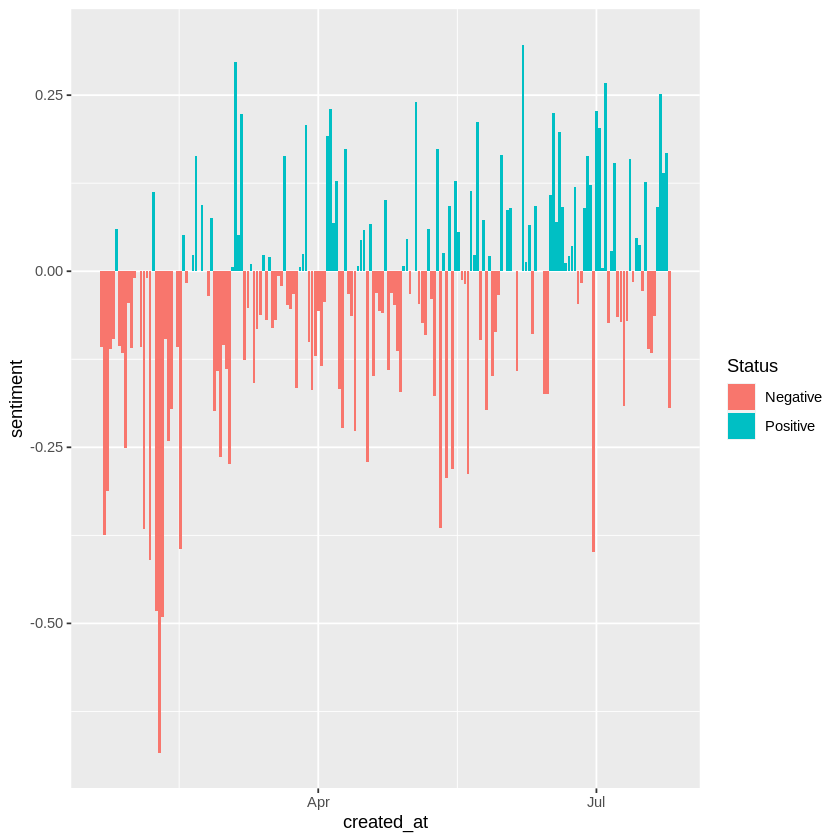

In [14]:
############## CNN BREAKING NEWS ####################
sentiment_cnn %>% 
  group_by(created_at) %>% 
  summarize(sentiment=mean(ave_sentiment)) %>% 
  mutate(Status=ifelse(sentiment>0,'Positive','Negative')) %>% 
  ggplot(aes(x=created_at,y=sentiment,fill=Status)) + 
  geom_col()

`summarise()` ungrouping output (override with `.groups` argument)



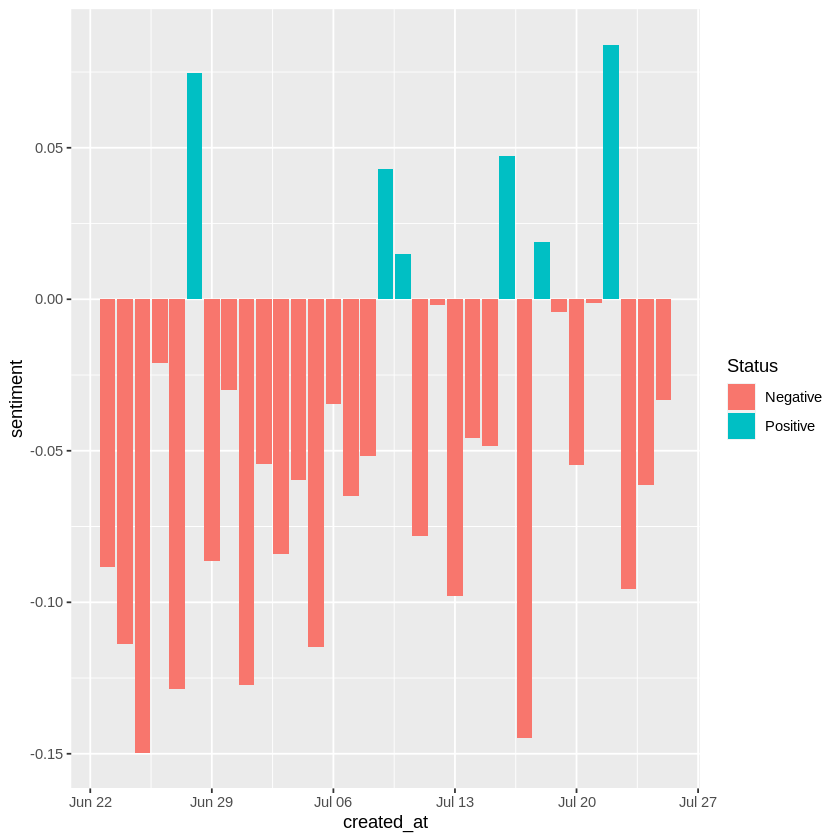

In [15]:
############## NEW YORK TIMES ##############################
sentiment_nyt %>% 
  group_by(created_at) %>% 
  summarize(sentiment=mean(ave_sentiment)) %>% 
  mutate(Status=ifelse(sentiment>0,'Positive','Negative')) %>% 
  ggplot(aes(x=created_at,y=sentiment,fill=Status)) + 
  geom_col()

`summarise()` ungrouping output (override with `.groups` argument)



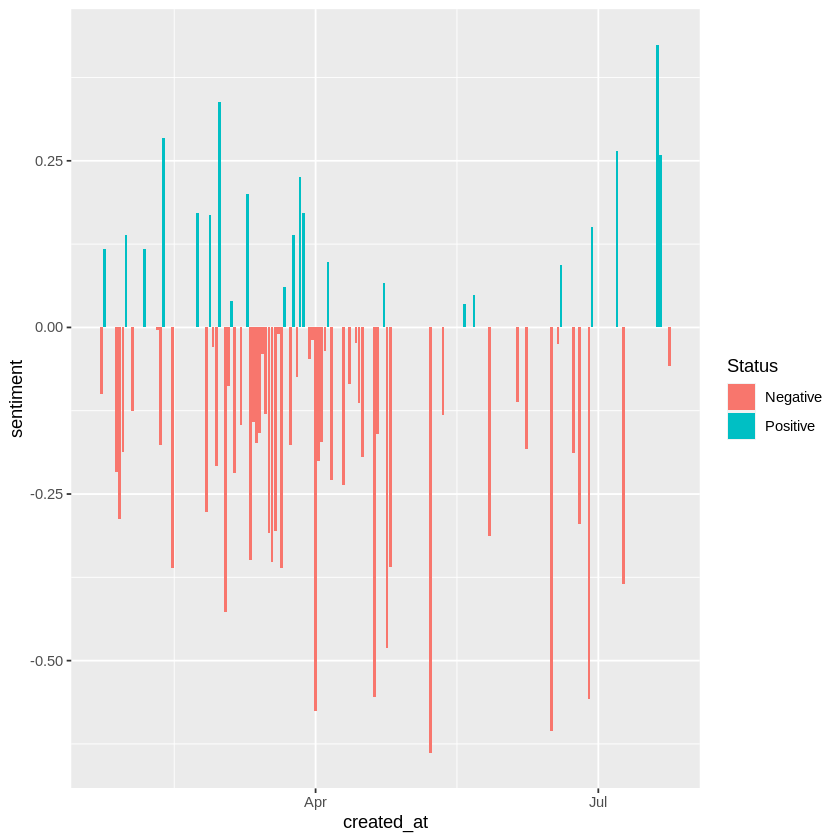

In [16]:
################# BBC BREAKING NEWS ############################
sentiment_bbc %>% 
  group_by(created_at) %>% 
  summarize(sentiment=mean(ave_sentiment)) %>% 
  mutate(Status=ifelse(sentiment>0,'Positive','Negative')) %>% 
  ggplot(aes(x=created_at,y=sentiment,fill=Status)) + 
  geom_col()

## Emotion Analysis
Examine the top 8 emotions for each twitter account 

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



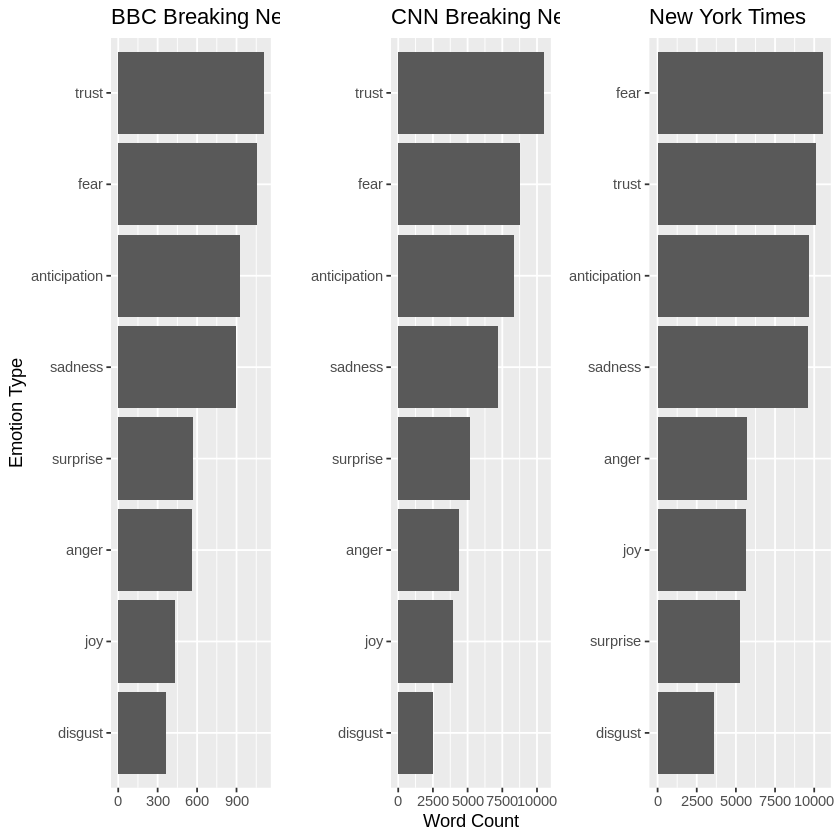

In [17]:
###########################################################
sentiment_cnn %>% 
  group_by(created_at) %>% 
  summarize(sentiment=mean(ave_sentiment))->sentiment_cnn_sum 
sentiment_bbc %>% 
  group_by(created_at) %>% 
  summarize(sentiment=mean(ave_sentiment))->sentiment_bbc_sum
################### CNN BBC JOINED #######################
sentiment_cnn_sum %>% 
  select(created_at,sentiment) %>% 
  inner_join(sentiment_bbc_sum,by='created_at',suffix=c('_cnn','_bbc')) %>% 
  mutate(sentiment_mean=(sentiment_cnn+sentiment_bbc)/2)->sentiment_cnn_bbc_joined
#############EMOTION #############################
emotion_cnn<-emotion_by(corona_cnn$text)
emotion_cnn %>% 
  filter(ave_emotion>0) %>% 
  group_by(emotion_type) %>% 
  summarize(word_count=sum(word_count)) %>% 
  arrange(desc(word_count)) %>% 
  head(8) %>% 
  mutate(emotion_type=fct_reorder(emotion_type,word_count)) %>% 
  ggplot(aes(emotion_type,word_count))+
  geom_col()+
  coord_flip()+
  labs(y='Word Count',x=' ',title='CNN Breaking News')->emotion_plot_cnn
emotion_bbc<-emotion_by(corona_bbc$text)
emotion_bbc %>% 
  filter(ave_emotion>0) %>% 
  group_by(emotion_type) %>% 
  summarize(word_count=sum(word_count)) %>% 
  arrange(desc(word_count)) %>% 
  head(8) %>% 
  mutate(emotion_type=fct_reorder(emotion_type,word_count)) %>% 
  ggplot(aes(emotion_type,word_count))+
  geom_col()+
  coord_flip()+
  labs(x='Emotion Type', y= " ", title='BBC Breaking News')->emotion_plot_bbc
emotion_nyt<-emotion_by(corona_nyt$text)
emotion_nyt %>% 
  filter(ave_emotion>0) %>% 
  group_by(emotion_type) %>% 
  summarize(word_count=sum(word_count)) %>% 
  arrange(desc(word_count)) %>% 
  head(8) %>% 
  mutate(emotion_type=fct_reorder(emotion_type,word_count)) %>% 
  ggplot(aes(emotion_type,word_count))+
  geom_col()+
  coord_flip()+
  labs(x=NULL,y=" ",title='New York Times')->emotion_plot_nyt

ggarrange(emotion_plot_bbc,emotion_plot_cnn,emotion_plot_nyt,
          ncol=3,nrow=1)
####################################################################

## Statistical Test
Granger-Causality and Cross-Correlation

In [ ]:
################## VIX ########################
vix<-read.csv(file.choose())
vix$Date<-as.Date(vix$Date,format = '%m/%d/%Y')
vix<-vix %>% 
  filter(Date>=as.Date('2020-01-01'))
changevix<-c()
for(i in 1:nrow(vix)){
  changevix[i]<-(vix$VIX.Close[i+1]-vix$VIX.Close[i])/vix$VIX.Close[i]
}
vix<-vix %>% mutate(changevix=changevix)
####################################################################
sentiment_cnn_bbc_joined %>% 
  inner_join(vix,by=c('created_at'='Date'))->vix_sent_joined
####################################################################
vix_sent_1<-vix_sent_joined[1:20,]
vix_sent_2<-vix_sent_joined[21:40,]
vix_sent_3<-vix_sent_joined[41:60,]
broom::tidy(grangertest(vix_sent_1$sentiment_mean,vix_sent_1$changevix,order=5))